In [1]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 4.2 MB/s eta 0:00:00


In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import numpy as np
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split

In [29]:
ddf = dd.read_csv('https://media.githubusercontent.com/media/maxgorodilov/Task_test/refs/heads/main/test_dataset.csv')

In [30]:
ddf.head(5)


,numeric_column,datetime_column,string_column
0,842.123671,2012-12-05 16:33:25,item_7286808
1,567.636532,2019-09-07 06:56:00,item_5389516
2,902.681319,2015-04-10 02:29:05,item_3624285
3,747.783391,2017-10-23 03:13:33,NaN
4,956.491082,2022-12-29 02:15:43,item_36814


In [32]:
# Удаление пустых / NA строк
ddf_not_null_dupl = ddf.dropna()

# Удаление дублей
ddf_not_null_dupl = ddf.drop_duplicates()

In [33]:
# Замена строк без чисел на пустые строки
ddf_not_null_dupl['numeric_column'] = ddf_not_null_dupl['numeric_column'].apply(lambda x: x if isinstance(x, (int, float)) else '')

/usr/local/lib/python3.10/dist-packages/dask_expr/_collection.py:4376: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('numeric_column', 'float64'))

  warnings.warn(meta_warning(meta))


In [44]:
# Преобразование столбца в тип datetime
ddf_not_null_dupl['datetime_column'] = dd.to_datetime(ddf_not_null_dupl['datetime_column'])

# Создание масок
mask1 = ddf_not_null_dupl['datetime_column'].dt.hour >= 1
mask2 = ddf_not_null_dupl['datetime_column'].dt.hour < 3

# Фильтрация DataFrame с использованием масок
ddf_filtr = ddf_not_null_dupl[mask1 & mask2]
ddf_filtr['hour'] = ddf_filtr['datetime_column'].dt.floor('H')

# Агрегируем данные и добавляем столбец 'hour'
ddf_aggr = ddf_filtr.groupby('hour').agg(
    unique_string_count=('string_column', 'nunique'),
    mean_numeric=('numeric_column', 'mean'),
    median_numeric=('numeric_column', 'median')
).reset_index()






Index(['hour', 'unique_string_count', 'mean_numeric', 'median_numeric'], dtype='object')


In [ ]:
"""SELECT
    DATE_TRUNC('hour', datetime_column) AS hour,
    COUNT(DISTINCT string_column) AS unique_string_count,
    AVG(numeric_column) AS mean_numeric,
    MEDIAN(numeric_column) AS median_numeric
FROM
    your_table_name
GROUP BY
    hour
ORDER BY
    hour """

In [46]:
ddf['datetime_column'] = dd.to_datetime(ddf['datetime_column'])

# Создаем новый столбец с округленным временем
ddf['hour'] = ddf['datetime_column'].dt.floor('H')

# Теперь мержим исходный датасет с агрегированными метриками
ddf_merged = dd.merge_asof(
    ddf.sort_values('datetime_column'),
    ddf_aggr.sort_values('hour'),
    left_on='datetime_column',
    right_on='hour',
    direction='backward'
)


In [57]:
df = pd.read_csv('https://media.githubusercontent.com/media/maxgorodilov/Task_test/refs/heads/main/test_dataset.csv')

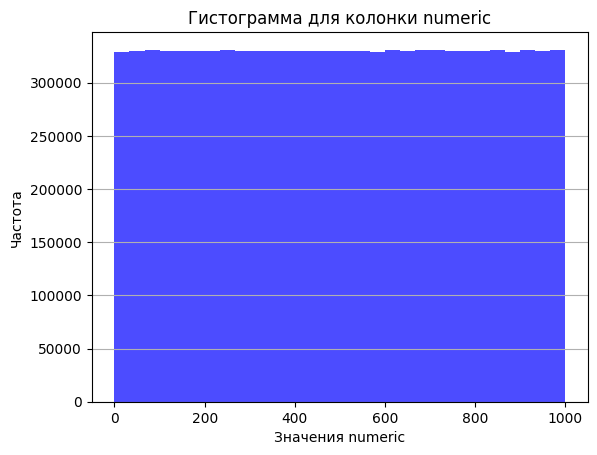

In [58]:
# Построение гистограммы

plt.hist(df['numeric_column'], bins=30, color='blue', alpha=0.7)
plt.title('Гистограмма для колонки numeric')
plt.xlabel('Значения numeric')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.show()

In [59]:
#Рассчитываем среднее и стандартное отклонение
mean = df['numeric_column'].mean()
std_dev = df['numeric_column'].std()
n = len(df['numeric_column'])

# Рассчитываем 95% доверительный интервал с использованием Z-распределения
confidence_level = 0.95
z_score = stats.norm.ppf((1 + confidence_level) / 2)  # Z-значение для 95% доверительного интервала
confidence_interval = (mean - z_score * (std_dev / (n ** 0.5)), mean + z_score * (std_dev / (n ** 0.5)))

print(f'95% доверительный интервал: {confidence_interval}')



95% доверительный интервал: (499.91804527449546, 500.2592450603573)


 АСИМПТОМАТИКА

БОЛЬШОЕ N (100 МИЛЛИОНОВ СТРОК ) , НЕТ ВЫБРОСОВ , IID

ЦЕНТРАЛЬНАЯ ПРЕДЕЛЬНАЯ ТЕОРЕМА

ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ МАТОЖИДАНИЯ Z ТЕСТ

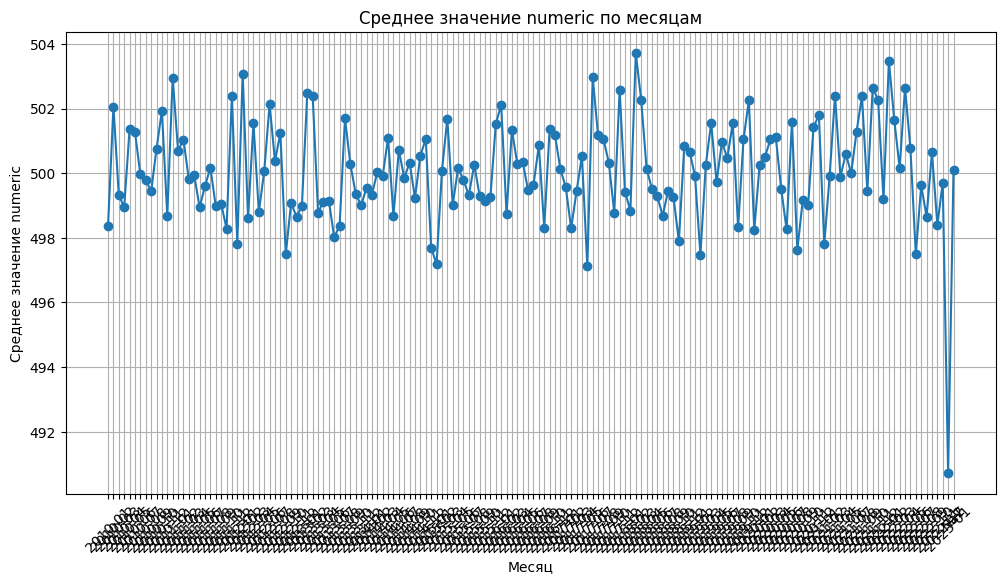

In [62]:
import dask.dataframe as dd

# Преобразуем DataFrame в Dask DataFrame
ddf = dd.from_pandas(df, npartitions=4)  # Количество партиций можно настроить

# Аналогичные операции с Dask
ddf['month'] = ddf['datetime_column'].dt.to_period('M')
monthly_mean = ddf.groupby('month')['numeric_column'].mean().compute()

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(monthly_mean.index.astype(str), monthly_mean.values, marker='o')
plt.title('Среднее значение numeric по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее значение numeric')
plt.xticks(rotation=45)
plt.grid()
plt.show()


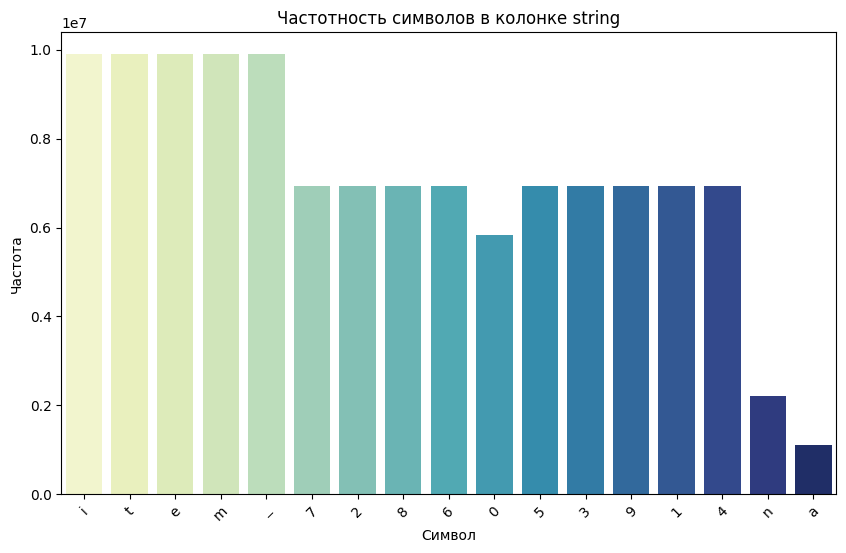

In [65]:


# Преобразуем все значения в строку и заменяем NaN на пустую строку
all_text = ''.join(df['string_column'].astype(str).fillna(''))

# Подсчитываем частоту символов с помощью Counter
char_freq = Counter(all_text)

# Создаем DataFrame для heatmap
heatmap_data = pd.DataFrame(char_freq.items(), columns=['Character', 'Frequency'])

# Строим тепловую карту
plt.figure(figsize=(10, 6))
sns.barplot(x='Character', y='Frequency', data=heatmap_data, palette='YlGnBu')
plt.title('Частотность символов в колонке string')
plt.xlabel('Символ')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()




Дополнительное задание

In [68]:
df_dop = pd.read_csv('https://media.githubusercontent.com/media/maxgorodilov/Task_test/refs/heads/main/test_dataset.csv')

In [77]:
# Случайное перемешивание
df_shuffled = df_dop.sample(frac=1, random_state=42).reset_index(drop=True)

# Определяем размеры частей
n = len(df_shuffled)
part1_size = int(n * 0.25)  # 25%
part2_size = int(n * 0.25)  # 25%
part3_size = n - part1_size - part2_size  # Остальные 50%

# Делим на части
part1 = df_shuffled.iloc[:part1_size]  # 25%
part2 = df_shuffled.iloc[part1_size:part1_size + part2_size]  # 25%
part3 = df_shuffled.iloc[part1_size + part2_size:]  # 50%

# Проверяем размеры частей
print(f"Размер Part 1: {len(part1)}")
print(f"Размер Part 2: {len(part2)}")
print(f"Размер Part 3: {len(part3)}")


Размер Part 1: 2750000
Размер Part 2: 2750000
Размер Part 3: 5500000


In [69]:
# Случайное перемешивание и деление на 3 части
df_shuffled = df_dop.sample(frac=1).reset_index(drop=True)
part1 = df_shuffled.iloc[int(len(df_shuffled) * 0.25)]  # 25%
part2 = df_shuffled.iloc[int(len(df_shuffled) * 0.25):int(len(df_shuffled) * 0.5)]  # 25%
part3 = df_shuffled.iloc[int(len(df_shuffled) * 0.5):]  # 50%


In [78]:
from scipy import stats
"""ANOVA: Использован метод дисперсионного анализа для проверки статистической значимости различий между средними значениями трех групп.

Сила эффекта: Рассчитан η² для оценки доли вариации, объясняемой группами, что позволяет понять, насколько значительными являются различия."""

# Выполняем ANOVA
f_statistic, p_value = stats.f_oneway(part1['numeric_column'].dropna(),
                                       part2['numeric_column'].dropna(),
                                       part3['numeric_column'].dropna())

print(f"F-статистика: {f_statistic}, P-значение: {p_value}")



F-статистика: 0.30306337167646824, P-значение: 0.7385522989631612


ВЫВОД:

H0: СРЕДНИЕ ЗНАЧЕНИЯ НЕ ИМЕЮТ СТАТИСТИЧЕСКИХ РАЗЛИЧИЙ

P-значение: 0.7385522989631612

ТРАКТОВКА: Вероятность встретить такие и более экстремальные значения при условии верности нулевой гипотезы состовляет 0,7 , что больше чем альфа - критерий значимости (0,05)

ЗНАЧИТ ВЕРОЯТНОСТЬ ВСТРЕТИТЬ ТАКИЕ ЗНАЧЕНИЯ БОЛЬШАЯ

РАЗЛИЧИЯ СТАТИСТИЧЕСКИ НЕ ЗНАЧИМЫ

F-статистика: 0.30306337167646824
говорит о том, что различия между группами незначительны.

In [81]:
# Рассчитываем η²
n_total = len(df_dop)
n_part1 = len(part1)
n_part2 = len(part2)
n_part3 = len(part3)

ss_total = ((df_dop['numeric_column'].dropna() - df_dop['numeric_column'].mean()) ** 2).sum()
ss_between = (n_part1 * (part1['numeric_column'].mean() - df_dop['numeric_column'].mean()) ** 2 +
               n_part2 * (part2['numeric_column'].mean() - df_dop['numeric_column'].mean()) ** 2 +
               n_part3 * (part3['numeric_column'].mean() - df_dop['numeric_column'].mean()) ** 2)

eta_squared = ss_between / ss_total
print(f"Сила эффекта (η²): {eta_squared}")

Сила эффекта (η²): 6.803041603751049e-08


Значение  6.80 × 10⁻⁸  близко к 0, что указывает на то, что фактор (группы) практически не объясняет вариацию в данных.


Низкое значение η² говорит о том, что различия между группами малозначительны с практической точки зрения. Это может свидетельствовать о том, что выбранные группы имеют схожие характеристики по измеряемой переменной.

ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ 2


1.Логистическая регрессия (но нужны дополнительные данные о товаре)


2.Частотный подход ( тогда вероятность 0)

3.Баесовский подход (Задать априорное распределение, например,  Beta(1, 1)  (равномерное).

Обновить распределение на основе  данных:

   • У нас 0 успешных и 200 неуспешных прототипов.

   • Обновленное распределение будет  Beta(1 + 0, 1 + 200) = Beta(1, 201) .

Найти ожидаемое значение (среднее) этого распределения:

E[X] = α / α + β = 1 / 1 + 201 = 1 / 202 ≈ 0.00495

